In [9]:
import QuantLib as ql

calendar = ql.TARGET()
settlementDays = 2

todaysDate = ql.Date(26, 8, 2016)
ql.Settings.instance().evaluationDate = todaysDate

todays_EONIA_quote = -0.00341
discounting_yts_handle = ql.RelinkableYieldTermStructureHandle()
on_index = ql.Eonia(discounting_yts_handle)
on_index.addFixing(todaysDate, todays_EONIA_quote / 100.0)

deposits = {(0, 1, ql.Days): todays_EONIA_quote}

ois = {
    (1, ql.Weeks): -0.342,
    (1, ql.Months): -0.344,
    (3, ql.Months): -0.349,
    (6, ql.Months): -0.363,
    (1, ql.Years): -0.389,
}


In [10]:
for sett_num, n, unit in deposits.keys():
    deposits[(sett_num, n, unit)] = ql.SimpleQuote(deposits[(sett_num, n, unit)] / 100.0)

for n, unit in ois.keys():
    ois[(n, unit)] = ql.SimpleQuote(ois[(n, unit)] / 100.0)

dayCounter = ql.Actual360()

depositHelpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(deposits[(sett_num, n, unit)]),
        ql.Period(n, unit),
        sett_num,
        calendar,
        ql.ModifiedFollowing,
        True,
        dayCounter,
    )
    for sett_num, n, unit in deposits.keys()
]

oisHelpers = [
    ql.OISRateHelper(
        settlementDays, ql.Period(n, unit),
        ql.QuoteHandle(ois[(n, unit)]), on_index,
        discounting_yts_handle)
    for n, unit in ois.keys()
]

rateHelpers = depositHelpers + oisHelpers

oisSwapCurve = ql.PiecewiseFlatForward(todaysDate, rateHelpers, ql.Actual360())

In [11]:
oisSwapCurve.discount(1.0)

for key, rate_helper in zip(ois.keys(), oisHelpers):
    expected = ois[key].value()
    calculated = rate_helper.impliedQuote()
    print(expected, calculated)

-0.0034200000000000003 -0.003419999999998424
-0.00344 -0.00344000000000036
-0.0034899999999999996 -0.0034900000000000994
-0.00363 -0.003629999999999888
-0.0038900000000000002 -0.003890000000005829


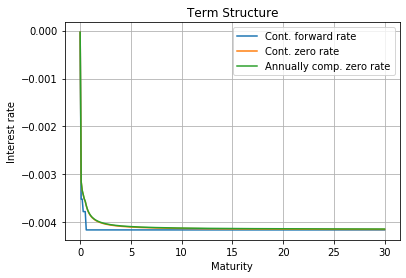

In [12]:
import matplotlib.pyplot as plt
def plot(yts_curve, years=30.0, stepsize=0.1):
        times = [k * stepsize for k in range(int(round(years / stepsize, 0)) + 1)]
        continuousForwd = [
            yts_curve.forwardRate(time, time, ql.Continuous, ql.Annual, True).rate()
            for time in times
        ]
        continuousZeros = [
            yts_curve.zeroRate(time, ql.Continuous, ql.Annual, True).rate()
            for time in times
        ]
        annualZeros = [
            yts_curve.zeroRate(time, ql.Compounded, ql.Annual, True).rate()
            for time in times
        ]
        # print(times, continuousForwd, continuousZeros, annualZeros)
        plt.plot(times, continuousForwd, label="Cont. forward rate")
        plt.plot(times, continuousZeros, label="Cont. zero rate")
        plt.plot(times, annualZeros, label="Annually comp. zero rate")
        plt.legend()
        plt.title(f"""Term Structure""")
        plt.xlabel("Maturity")
        plt.ylabel("Interest rate")
        plt.grid()
        plt.show()
plot(oisSwapCurve)